# DeepTendies Example Notebook
## Hyper parameter optimization for AAPL data

* Author: Mike Lasby
* Date: 2021-04-11
* Last Updated: 2021-04-14
* Reviewed by: N/A

In [ ]:
%%bash
pip install -r https://raw.githubusercontent.com/deeptendies/deeptendies/master/requirements.txt && pip install git+https://github.com/deeptendies/deeptendies


  Cloning https://github.com/deeptendies/deeptendies to /tmp/pip-req-build-3k0ve_jx
  Created wheel for deeptendies: filename=deeptendies-0.0.1.dev0-cp37-none-any.whl size=19341 sha256=19327c107879b883633e477e7800d54602ddafb641e6d1d03c1147424943793a
  Stored in directory: /tmp/pip-ephem-wheel-cache-3heig4cj/wheels/7b/aa/b9/42f9bb23e2644e4f8ab23852dd55e3b0a1bcdc518dd13f1631
Successfully built deeptendies


  Running command git clone -q https://github.com/deeptendies/deeptendies /tmp/pip-req-build-3k0ve_jx


# Data ingestion from API

In [ ]:
from deeptendies.stock_data import StockData
from deeptendies.trainer import Trainer
from deeptendies.model_metrics import ModelMetrics
# NOTE: Update stock name !
STOCK_NAME = 'KO'
closing_data = StockData(STOCK_NAME, days=7300, api_key="c1h8m1n48v6t9ghtpkh0")

Note: the following two cells is fo us to have the same appl data for generating the final report. **If you are using your own ticker, do not run the next 2 cells. just use the cell above**

In [ ]:
# TODO: final report only cell #1
# run this to connect gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Ingestion from static data store
This data is used for hyper parameter tuning or other experimentation using a common dataset

In [ ]:
# # TODO: final report only cell #2
# # run this to load team_data
# import pandas as pd
# # TODO: Please use this for getting final data to generate the final report
# aapl_finrep_data = "/content/drive/MyDrive/enel645-team-drive/Final-Project/AAPL_7300.csv" # stock.df.to_csv(aapl_finrep_data)
# aapl_data_df = pd.read_csv(aapl_finrep_data, index_col=0)
# aapl_data_df['t'] = pd.to_datetime(aapl_data_df['t'])
# closing_data.df = aapl_data_df

#Targets: 
  * Tomorrow's closing price 
  * n<sup>th</sup> day high/low (eg., high price in next 5 days, low price in next 5 days)

In [ ]:
from copy import deepcopy 
# Prepare 3 df's one for each target (5 day high, 5 day low, & tomorrow's closing price )
five_day_low_data = deepcopy(closing_data)
five_day_high_data = deepcopy(closing_data)
dfs = [closing_data, five_day_high_data, five_day_low_data]

# Data Exploration

In [ ]:
closing_data.df

,c,h,l,o,s,t,v,wma
0,23.500,23.625,23.140,23.525,ok,2001-04-20,4583600,0.000000
1,23.725,23.950,23.515,23.750,ok,2001-04-23,3330500,0.000000
2,23.695,24.225,23.585,23.725,ok,2001-04-24,4343400,23.672500
3,24.100,24.200,23.700,23.750,ok,2001-04-25,3247700,23.902500
4,23.450,23.990,23.450,23.800,ok,2001-04-26,4296500,23.707500
...,...,...,...,...,...,...,...,...
5022,53.120,53.380,52.970,53.170,ok,2021-04-08,9695561,53.185000
5023,53.180,53.280,52.810,53.170,ok,2021-04-09,10828169,53.176667
5024,53.350,53.550,53.095,53.330,ok,2021-04-12,8565279,53.255000
5025,53.090,53.285,52.810,53.040,ok,2021-04-13,11071689,53.191667


In [ ]:
for df in dfs: 
  df.engineer_features() #engineer all features
closing_data.df

,c,h,l,o,s,t,v,wma,day_of_week,day_of_year,is_quarter_end,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,23.500,23.625,23.140,23.525,ok,2001-04-20,4583600,0.000000,4,110,False,NaN,23.421667,NaN,23.421667,NaN,23.421667,23.950,23.515,24.225,23.515,24.225,23.000,24.225,22.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23.725,23.950,23.515,23.750,ok,2001-04-23,3330500,0.000000,0,113,False,NaN,23.551423,NaN,23.551423,NaN,23.551423,24.225,23.585,24.225,23.450,24.225,22.925,24.225,22.925,23.625,23.140,NaN,NaN,NaN,NaN,NaN,NaN
2,23.695,24.225,23.585,23.725,ok,2001-04-24,4343400,23.672500,1,114,False,NaN,23.651907,NaN,23.651907,NaN,23.651907,24.200,23.700,24.200,23.000,24.200,22.925,24.200,22.925,23.950,23.515,NaN,NaN,NaN,NaN,NaN,NaN
3,24.100,24.200,23.700,23.750,ok,2001-04-25,3247700,23.902500,2,115,False,NaN,23.724818,NaN,23.724818,NaN,23.724818,23.990,23.450,23.990,22.925,24.100,22.925,24.100,22.910,24.225,23.585,NaN,NaN,NaN,NaN,NaN,NaN
4,23.450,23.990,23.450,23.800,ok,2001-04-26,4296500,23.707500,3,116,False,NaN,23.704245,NaN,23.704245,NaN,23.704245,23.750,23.000,24.100,22.925,24.100,22.925,24.100,22.910,24.200,23.700,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,53.120,53.380,52.970,53.170,ok,2021-04-08,9695561,53.185000,3,98,False,51.100766,51.209802,51.453318,50.730376,52.495905,51.720908,53.280,52.810,53.550,52.810,NaN,NaN,NaN,NaN,53.500,53.120,53.215,52.29,53.94,51.17,53.94,50.170
5023,53.180,53.280,52.810,53.170,ok,2021-04-09,10828169,53.176667,4,99,False,51.135176,51.206603,51.548549,50.809678,52.609714,51.795184,53.550,53.095,53.550,52.650,NaN,NaN,NaN,NaN,53.380,52.970,53.650,52.29,53.94,51.76,53.94,50.320
5024,53.350,53.550,53.095,53.330,ok,2021-04-12,8565279,53.255000,0,102,False,51.172919,51.202296,51.646800,50.869931,52.728762,51.902213,53.285,52.810,NaN,NaN,NaN,NaN,NaN,NaN,53.280,52.810,53.650,52.29,53.94,52.29,53.94,50.825
5025,53.090,53.285,52.810,53.040,ok,2021-04-13,11071689,53.191667,1,103,False,51.205533,51.191022,51.731561,50.951288,52.808810,51.978786,53.190,52.650,NaN,NaN,NaN,NaN,NaN,NaN,53.550,53.095,53.650,52.90,53.79,52.29,53.94,51.150


In [ ]:
# reorder columns! NOTE: REQUIRED ORDERING! columns in index [0:x] are not to be normalized. Column at index x is the target vector. Column idx > x will be normalized. 
closing_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_high_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end',
                        'next_5_high', 'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low', 'next_5_low', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])

five_day_low_data.reorder_cols(['day_of_week',
                        'day_of_year',
                        'is_quarter_end', 'next_5_low', 
                        'c', 'h', 'l', 'o', 's', 't', 'v', 'wma',
                        '100wma', '100mvwap', '50wma', '50mvwap', '20wma','20mvwap', 'next_1_high', 'next_1_low',
                        'next_3_high', 'next_3_low','next_5_high', 'next_7_high', 'next_7_low',
                        'last_1_high','last_1_low', 'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low','last_7_high', 'last_7_low'])
closing_data.df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,s,t,v,wma,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap,next_1_high,next_1_low,next_3_high,next_3_low,next_5_high,next_5_low,next_7_high,next_7_low,last_1_high,last_1_low,last_3_high,last_3_low,last_5_high,last_5_low,last_7_high,last_7_low
0,4,110,False,23.500,23.625,23.140,23.525,ok,2001-04-20,4583600,0.000000,NaN,23.421667,NaN,23.421667,NaN,23.421667,23.950,23.515,24.225,23.515,24.225,23.000,24.225,22.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,113,False,23.725,23.950,23.515,23.750,ok,2001-04-23,3330500,0.000000,NaN,23.551423,NaN,23.551423,NaN,23.551423,24.225,23.585,24.225,23.450,24.225,22.925,24.225,22.925,23.625,23.140,NaN,NaN,NaN,NaN,NaN,NaN
2,1,114,False,23.695,24.225,23.585,23.725,ok,2001-04-24,4343400,23.672500,NaN,23.651907,NaN,23.651907,NaN,23.651907,24.200,23.700,24.200,23.000,24.200,22.925,24.200,22.925,23.950,23.515,NaN,NaN,NaN,NaN,NaN,NaN
3,2,115,False,24.100,24.200,23.700,23.750,ok,2001-04-25,3247700,23.902500,NaN,23.724818,NaN,23.724818,NaN,23.724818,23.990,23.450,23.990,22.925,24.100,22.925,24.100,22.910,24.225,23.585,NaN,NaN,NaN,NaN,NaN,NaN
4,3,116,False,23.450,23.990,23.450,23.800,ok,2001-04-26,4296500,23.707500,NaN,23.704245,NaN,23.704245,NaN,23.704245,23.750,23.000,24.100,22.925,24.100,22.925,24.100,22.910,24.200,23.700,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,3,98,False,53.120,53.380,52.970,53.170,ok,2021-04-08,9695561,53.185000,51.100766,51.209802,51.453318,50.730376,52.495905,51.720908,53.280,52.810,53.550,52.810,NaN,NaN,NaN,NaN,53.500,53.120,53.215,52.29,53.94,51.17,53.94,50.170
5023,4,99,False,53.180,53.280,52.810,53.170,ok,2021-04-09,10828169,53.176667,51.135176,51.206603,51.548549,50.809678,52.609714,51.795184,53.550,53.095,53.550,52.650,NaN,NaN,NaN,NaN,53.380,52.970,53.650,52.29,53.94,51.76,53.94,50.320
5024,0,102,False,53.350,53.550,53.095,53.330,ok,2021-04-12,8565279,53.255000,51.172919,51.202296,51.646800,50.869931,52.728762,51.902213,53.285,52.810,NaN,NaN,NaN,NaN,NaN,NaN,53.280,52.810,53.650,52.29,53.94,52.29,53.94,50.825
5025,1,103,False,53.090,53.285,52.810,53.040,ok,2021-04-13,11071689,53.191667,51.205533,51.191022,51.731561,50.951288,52.808810,51.978786,53.190,52.650,NaN,NaN,NaN,NaN,NaN,NaN,53.550,53.095,53.650,52.90,53.79,52.29,53.94,51.150


In [ ]:
# get cleaned df
# NOTE: See doc strings! Default behavior will drop NaNs
closing_price_df = closing_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high',
                                                            'next_5_low', 'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                            'last_3_high', 'last_3_low', 'last_5_high', 'last_5_low', 'last_7_high',
                                                            'last_7_low', "s", "wma"])

five_day_high_df = five_day_high_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_low',
                                                                  'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                  'last_3_high', 'last_3_low', 'last_5_low', 'last_7_high',
                                                                  'last_7_low', "s", "wma", "last_5_high"])
   

five_day_low_df = five_day_low_data.get_cleaned_data(drop_cols=['next_1_high', 'next_1_low', 'next_3_high', 'next_3_low', 'next_5_high', 
                                                                'next_7_high', 'next_7_low', 'last_1_high', 'last_1_low',
                                                                'last_3_high', 'last_3_low', 'last_5_high', 'last_7_high',
                                                                'last_7_low', "s", "wma", 'last_5_low'])

closing_price_df

,day_of_week,day_of_year,is_quarter_end,c,h,l,o,v,100wma,100mvwap,50wma,50mvwap,20wma,20mvwap
t,,,,,,,,,,,,,,
2001-09-17,0,260,0,25.100,25.100,24.355,24.750,10135600,23.325207,23.240734,23.735757,23.428256,24.577548,24.385082
2001-09-18,1,261,0,24.735,25.155,24.475,25.150,5556000,23.354435,23.259126,23.791247,23.474585,24.615381,24.451701
2001-09-19,2,262,0,24.750,24.970,24.165,24.860,7208000,23.383715,23.278599,23.845808,23.516452,24.646476,24.530896
2001-09-20,3,263,0,24.175,24.705,24.150,24.405,8299300,23.401406,23.293521,23.876424,23.556229,24.618238,24.552069
2001-09-21,4,264,0,23.400,23.915,22.625,23.000,11527100,23.403655,23.288809,23.875427,23.556212,24.514667,24.451347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-08,3,98,0,53.120,53.380,52.970,53.170,9695561,51.100766,51.209802,51.453318,50.730376,52.495905,51.720908
2021-04-09,4,99,0,53.180,53.280,52.810,53.170,10828169,51.135176,51.206603,51.548549,50.809678,52.609714,51.795184
2021-04-12,0,102,0,53.350,53.550,53.095,53.330,8565279,51.172919,51.202296,51.646800,50.869931,52.728762,51.902213


# Let's see our data!
## This is just the closing price, our first target (next day close)

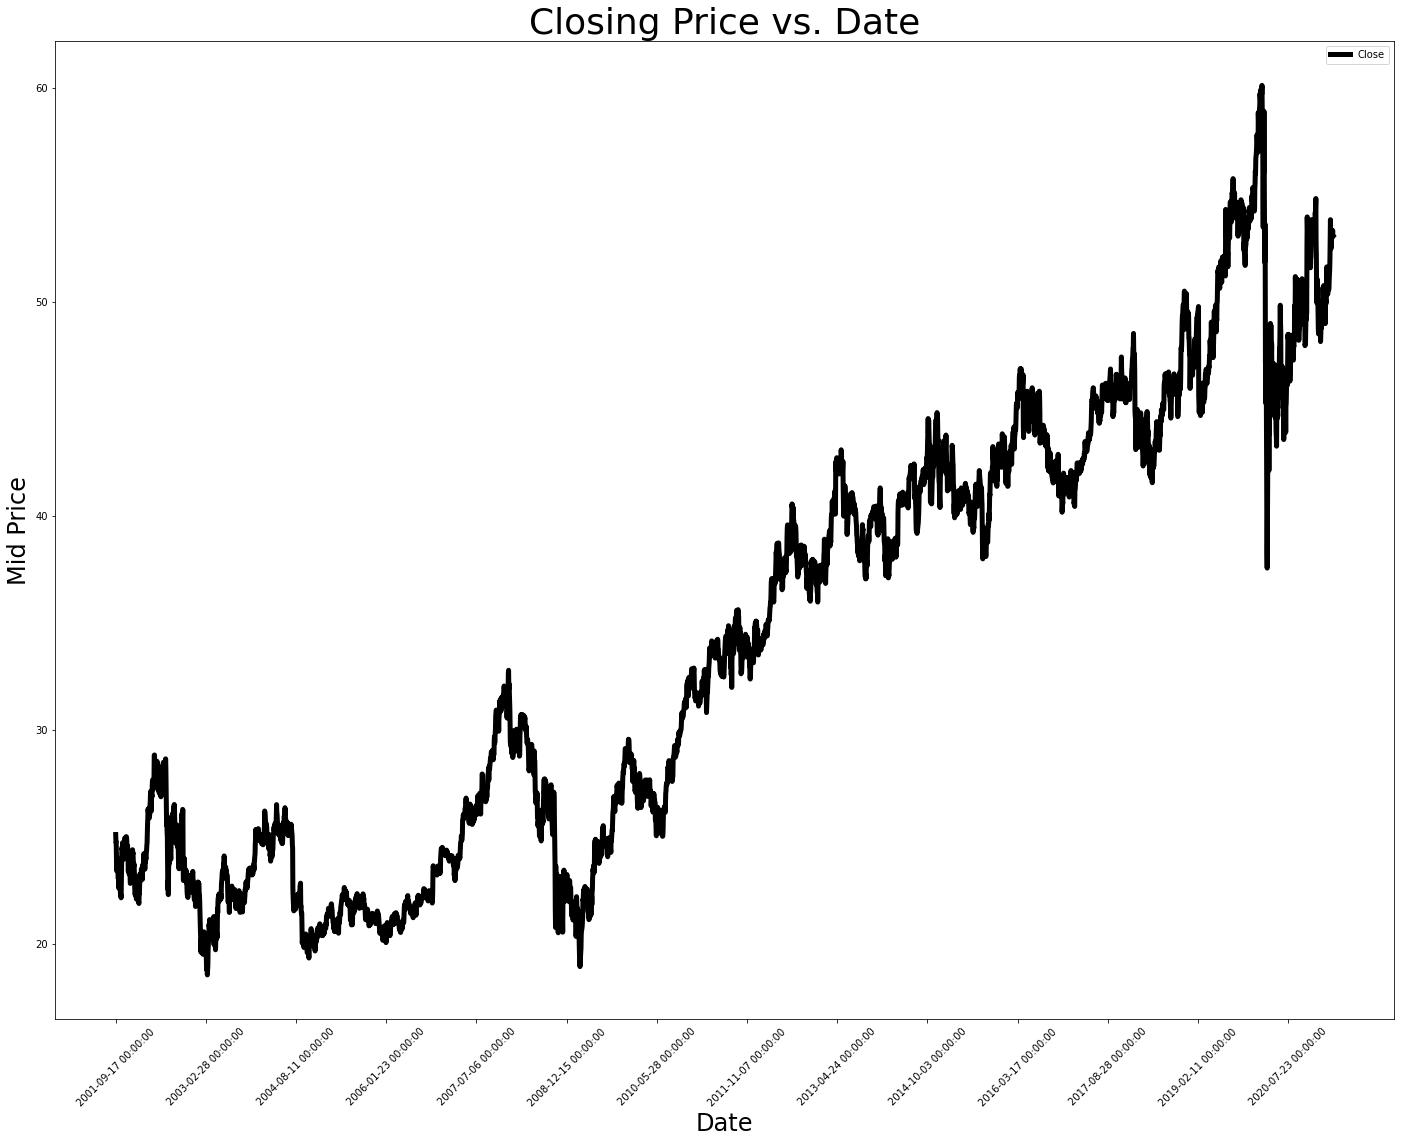

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df, plot_features=False)
fig.show()

# Here's the next 5 day high/low prices overlaid over closing
Let's see the last 10% of data so we can see the different trends 

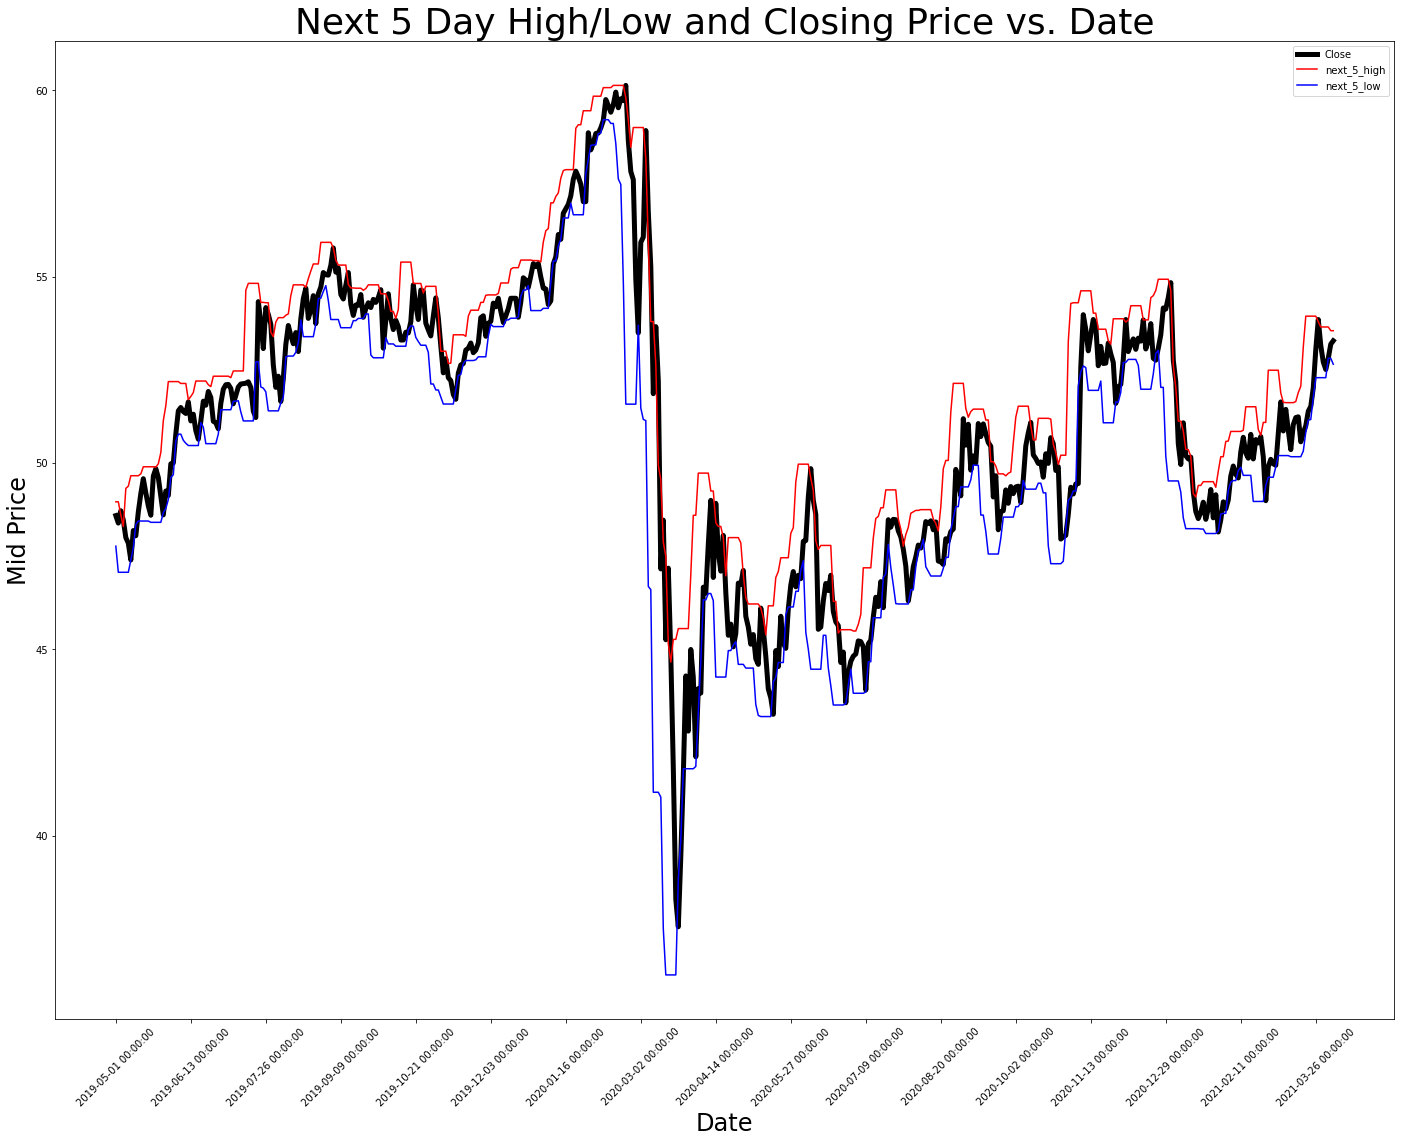

In [ ]:
dates = closing_price_df.index
start_date = dates[int(len(dates)*.9)]
end_date = dates[-1]
plot_df = five_day_high_df.join(five_day_low_df['next_5_low'])
fig = closing_data.get_next_high_low_plot(use_custom_df = True, df = plot_df.loc[start_date: end_date],  x_step=30)
fig.show()

# Technical Indicators 
Here we have plotted the 20, 50, and 100 weighted moving averages and volumed weighted average prices. Let's check out our indicators over the last 10 % of our data

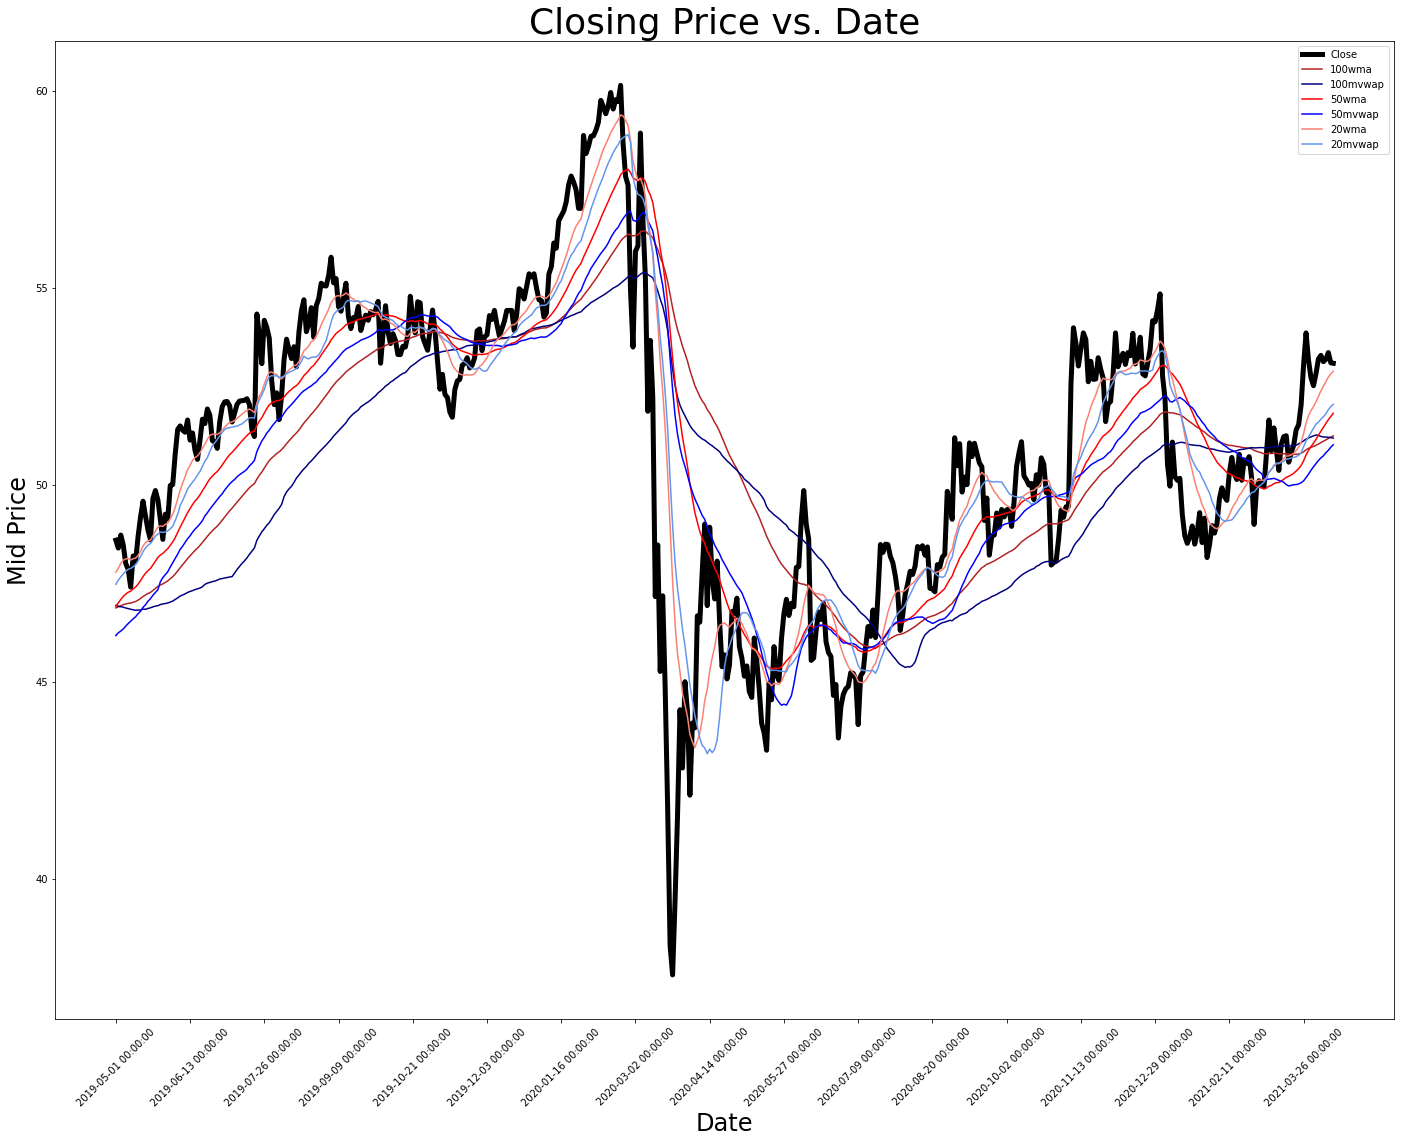

In [ ]:
fig = closing_data.get_line_plot( use_custom_df = True, df = closing_price_df.loc[start_date: end_date], plot_features=True, x_step=30)
fig.show()

# Define Model Names and Constants

In [ ]:
DIR_LOCATION = "./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/"
STOCK_NAME = STOCK_NAME
CLOSING_MODEL_NAME = f'{STOCK_NAME}_CLOSING_MODEL.h5'
FIVE_DAY_HIGH_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_HIGH_MODEL.h5'
FIVE_DAY_LOW_MODEL_NAME = f'{STOCK_NAME}_FIVE_DAY_LOW_MODEL.h5'

# Define callbacks

In [ ]:
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')

import datetime
import os


closing_early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

high_early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

low_early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)

closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + CLOSING_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_high_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_HIGH_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')

five_low_closing_monitor = tf.keras.callbacks.ModelCheckpoint(DIR_LOCATION + FIVE_DAY_LOW_MODEL_NAME, 
                                             monitor='loss',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = DIR_LOCATION,
                                                      histogram_freq=1,
                                                      write_graph=True,
                                                      write_images=False, 
                                                      update_freq='epoch')

closing_callbacks = [closing_monitor, closing_monitor, lr_schedule]

five_high_callbacks = [high_early_stop, five_high_closing_monitor, lr_schedule]

five_low_callbacks = [low_early_stop, five_low_closing_monitor, lr_schedule]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Model Architectures

In [ ]:
import tensorflow as tf
## TODO: Make sure this is best performing model 
def model(batch_size = 1, ishape = (100,5), lr = 1e-2):
  model_input = tf.keras.layers.Input(shape = ishape, batch_size = 1)
  l3 = tf.keras.layers.LSTM(units = 20, return_sequences = True, return_state = True, stateful=True)(model_input)  #Use False for only 1 dim return, True = full sequence of hidden states
  l4 = tf.keras.layers.LSTM(units = 20, return_sequences = False)(l3)  #Use False for only 1 dim return, True = full sequence of hidden states
  output = tf.keras.layers.Dense(1, activation = 'linear')(l4)
  model = tf.keras.Model(inputs = model_input, outputs = output)
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                loss = tf.keras.losses.mean_squared_error) 
  return model


#ishape should be (timesteps, n_features)
BATCH_SIZE = 1
closing_model = model(batch_size = BATCH_SIZE, ishape=(100, closing_price_df.shape[1]))
# 15 features in these models (next high )
five_day_high_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_high_df.shape[1]))
five_day_low_model = model(batch_size = BATCH_SIZE, ishape=(100, five_day_low_df.shape[1]))


# Get custom time series data generators
Note: These generators were developed to provide windowed normalization. For the next 5 day high/low, the last 5 values are copied from the last valid data to avoid information from future steps being passed into training. (ie., 94th value is copied into 95-100th values for feautres generated with future data)

In [ ]:
# How about windowed normalization? We got you covered! Here we will use a min max scaler, but you can also use a standard scaler by passing min_max_scaler=False
train_scaled_closing_data, test_scaled_closing_data = StockData.get_timeseries_generators(df=closing_price_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='c',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            target_idx = 3)


train_scaled_five_day_high, test_scaled_five_day_high = StockData.get_timeseries_generators(df=five_day_high_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_high',
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3)

train_scaled_five_day_low, test_scaled_five_day_low = StockData.get_timeseries_generators(df=five_day_low_df,
                                                                            test_percentage = 0.3, 
                                                                            target_col='next_5_low',   
                                                                            length=100,
                                                                            windowed_norm=True,
                                                                            min_max_scaler=True,
                                                                            batch_size=1, 
                                                                            mask = True, 
                                                                            mask_idx = 5, 
                                                                            target_idx = 3 )

# Prepare Trainers



In [ ]:
# Arnold schwarzenegger likes to train
arnold_closing = Trainer(None, closing_model, CLOSING_MODEL_NAME, train_scaled_closing_data, test_scaled_closing_data)
arnold_next_high = Trainer(None, five_day_high_model, FIVE_DAY_HIGH_MODEL_NAME, train_scaled_five_day_high, test_scaled_five_day_high)
arnold_next_low = Trainer(None, five_day_low_model, FIVE_DAY_LOW_MODEL_NAME, train_scaled_five_day_low, test_scaled_five_day_low)

# Training Model - Tomorrow's Closing Price

In [ ]:
arnold_closing.train_model(100, True, callbacks=closing_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 106s 32ms/step - loss: 0.1410

Epoch 00001: loss improved from inf to 0.14102, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_CLOSING_MODEL.h5

Epoch 00001: loss did not improve from 0.14102
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 106s 32ms/step - loss: 0.1372

Epoch 00002: loss improved from 0.14102 to 0.13720, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_CLOSING_MODEL.h5

Epoch 00002: loss did not improve from 0.13720
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3349/3349 [==============================] - 106s 32ms/step - loss: 0.1252

Epoch 00003: loss improved from 0.13720 to 0.12519, saving model to ./drive/MyDrive

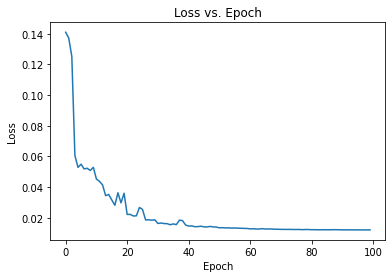

In [ ]:
fig = arnold_closing.graph_loss()

# Training Model - Next 5 Day High Price

In [ ]:
arnold_next_high.train_model(100, True, callbacks=five_high_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 116s 34ms/step - loss: 0.1950

Epoch 00001: loss improved from inf to 0.17291, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_FIVE_DAY_HIGH_MODEL.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 112s 34ms/step - loss: 0.1763

Epoch 00002: loss improved from 0.17291 to 0.17040, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_FIVE_DAY_HIGH_MODEL.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 114s 34ms/step - loss: 0.0881

Epoch 00003: loss improved from 0.17040 to 0.09134, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_FIVE_DAY_HIGH_MODEL.h5
Epoch 4/100

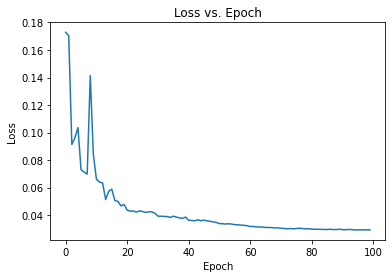

In [ ]:
fig = arnold_next_high.graph_loss()

# Training Model - Next 5 Day Low Price

In [ ]:
arnold_next_low.train_model(100, True, callbacks=five_low_callbacks)

TRAINING
Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 118s 35ms/step - loss: 0.1837

Epoch 00001: loss improved from inf to 0.16370, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_FIVE_DAY_LOW_MODEL.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 112s 33ms/step - loss: 0.1085

Epoch 00002: loss improved from 0.16370 to 0.09885, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_FIVE_DAY_LOW_MODEL.h5
Epoch 3/100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009999999776482582.
3346/3346 [==============================] - 111s 33ms/step - loss: 0.0799

Epoch 00003: loss improved from 0.09885 to 0.08413, saving model to ./drive/MyDrive/enel645-team-drive/Final-Project/saved-models/KO_FIVE_DAY_LOW_MODEL.h5
Epoch 4/100

E

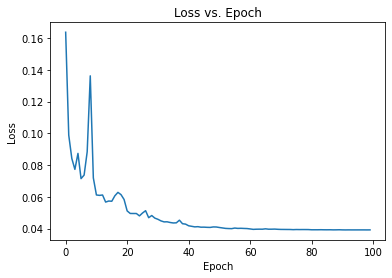

In [ ]:
fig = arnold_next_low.graph_loss()

# Results - Tomorrow's Closing Price

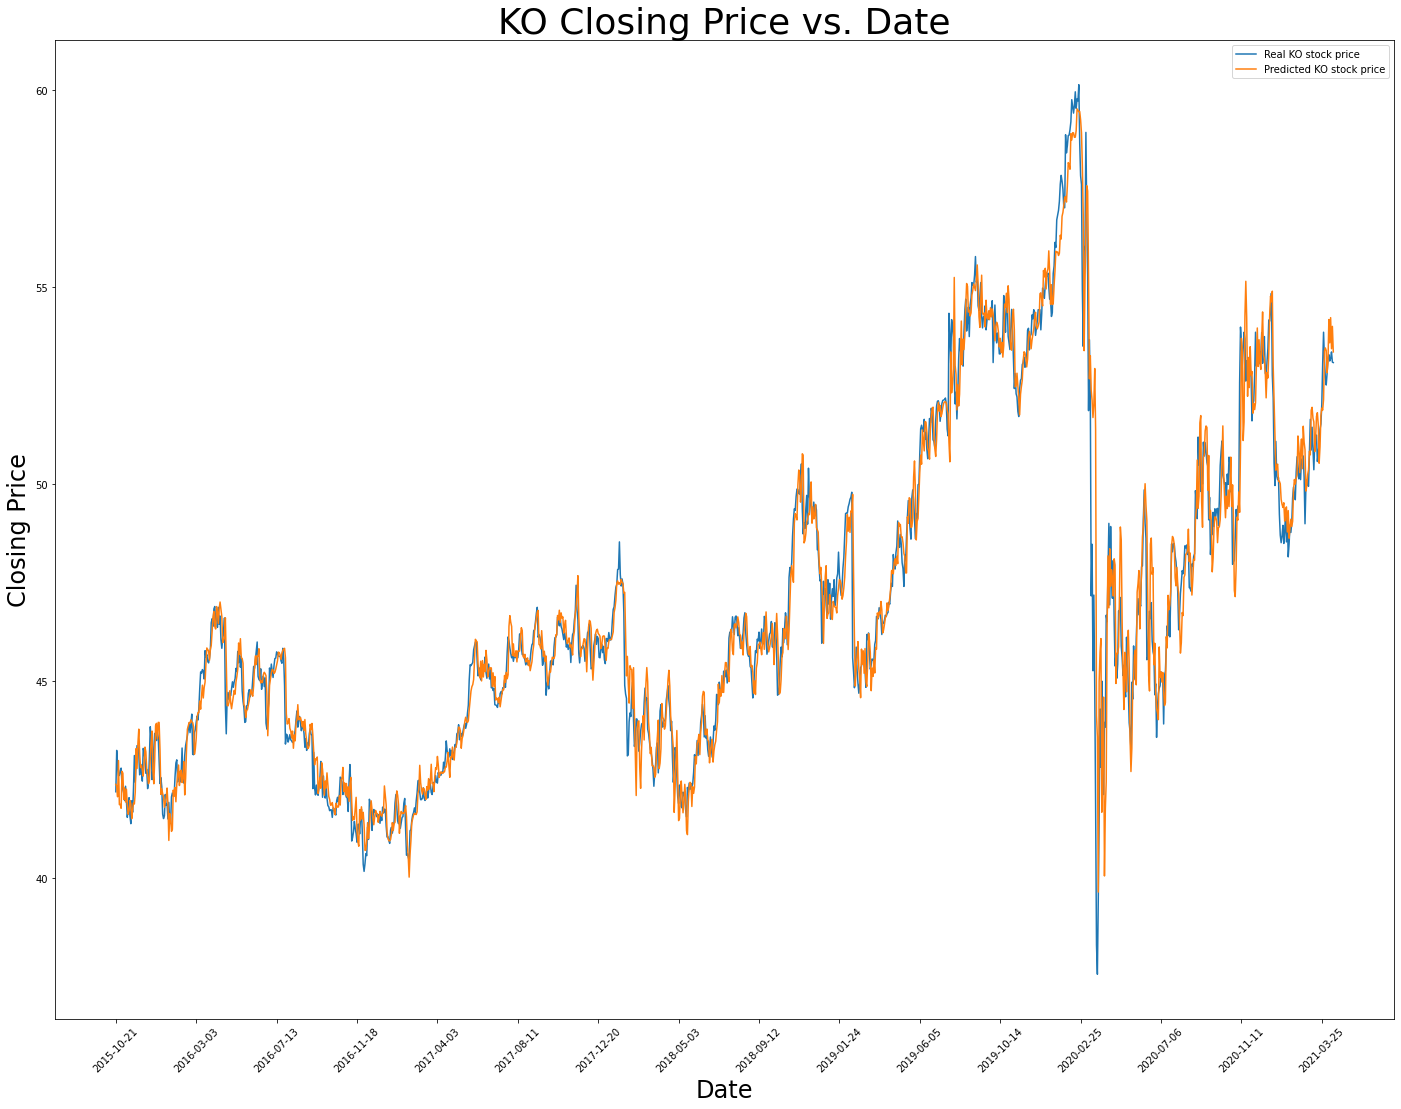

In [ ]:
from deeptendies.result_plots import ModelResultPlots
def get_results(df, train_data_gen, model, title = "Closing Price vs. Date", predicted_value_name = "stock price"): 
  train_idx, test_idx= StockData.get_train_test_split(df)
  days = [str(x).split("T")[0] for x in df.index[train_idx+train_data_gen.length:].values]
  predictions = model.get_predictions()
  y_true = predictions['actual']
  y_predicted = predictions['predicted']
  fig = ModelResultPlots.plot_predicted_vs_original_price(y_true, y_predicted, STOCK_NAME, days, x_step=91, title = title, predicted_value_name = predicted_value_name)
  return fig, y_true, y_predicted


fig, y_true, y_predicted = get_results(closing_price_df, train_scaled_closing_data, arnold_closing)
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{CLOSING_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

KO_CLOSING_MODEL.h5 achieved the folowing results:
Mean squared error:		 0.7833112056549577
Root mean squared error:	 0.885048702419792
Mean absolute error:		 0.5364051989250377
Mean absolute percentage error:	 0.011400896338307102
Mean percentage error:		 -0.0013443424818290737
Mean directional accuracy:	 0.4869375907111756


# Results - Next 5 Day High Price

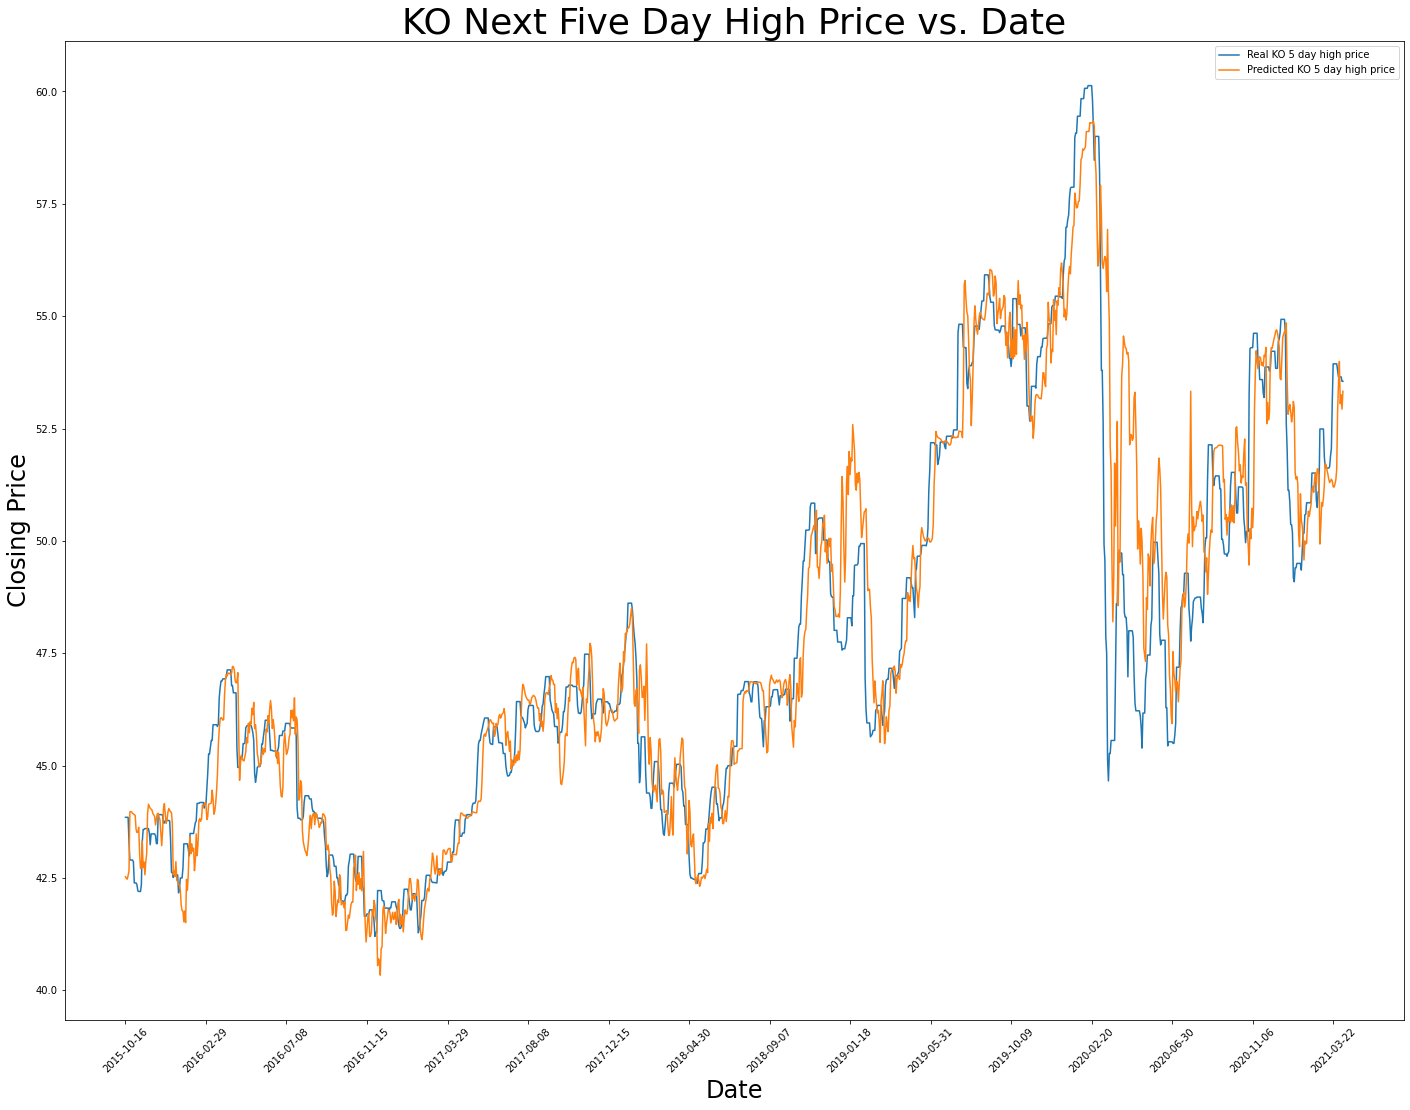

In [ ]:
fig, y_true, y_predicted = get_results(five_day_high_df, train_scaled_five_day_high, arnold_next_high, title = "Next Five Day High Price vs. Date", predicted_value_name = "5 day high price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_HIGH_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

KO_FIVE_DAY_HIGH_MODEL.h5 achieved the folowing results:
Mean squared error:		 2.1447426106483767
Root mean squared error:	 1.4644939776756942
Mean absolute error:		 0.9068839843838649
Mean absolute percentage error:	 0.018908547890966545
Mean percentage error:		 -0.0038333249305102643
Mean directional accuracy:	 0.24636627906976744


# Results - Next 5 Day Low Price

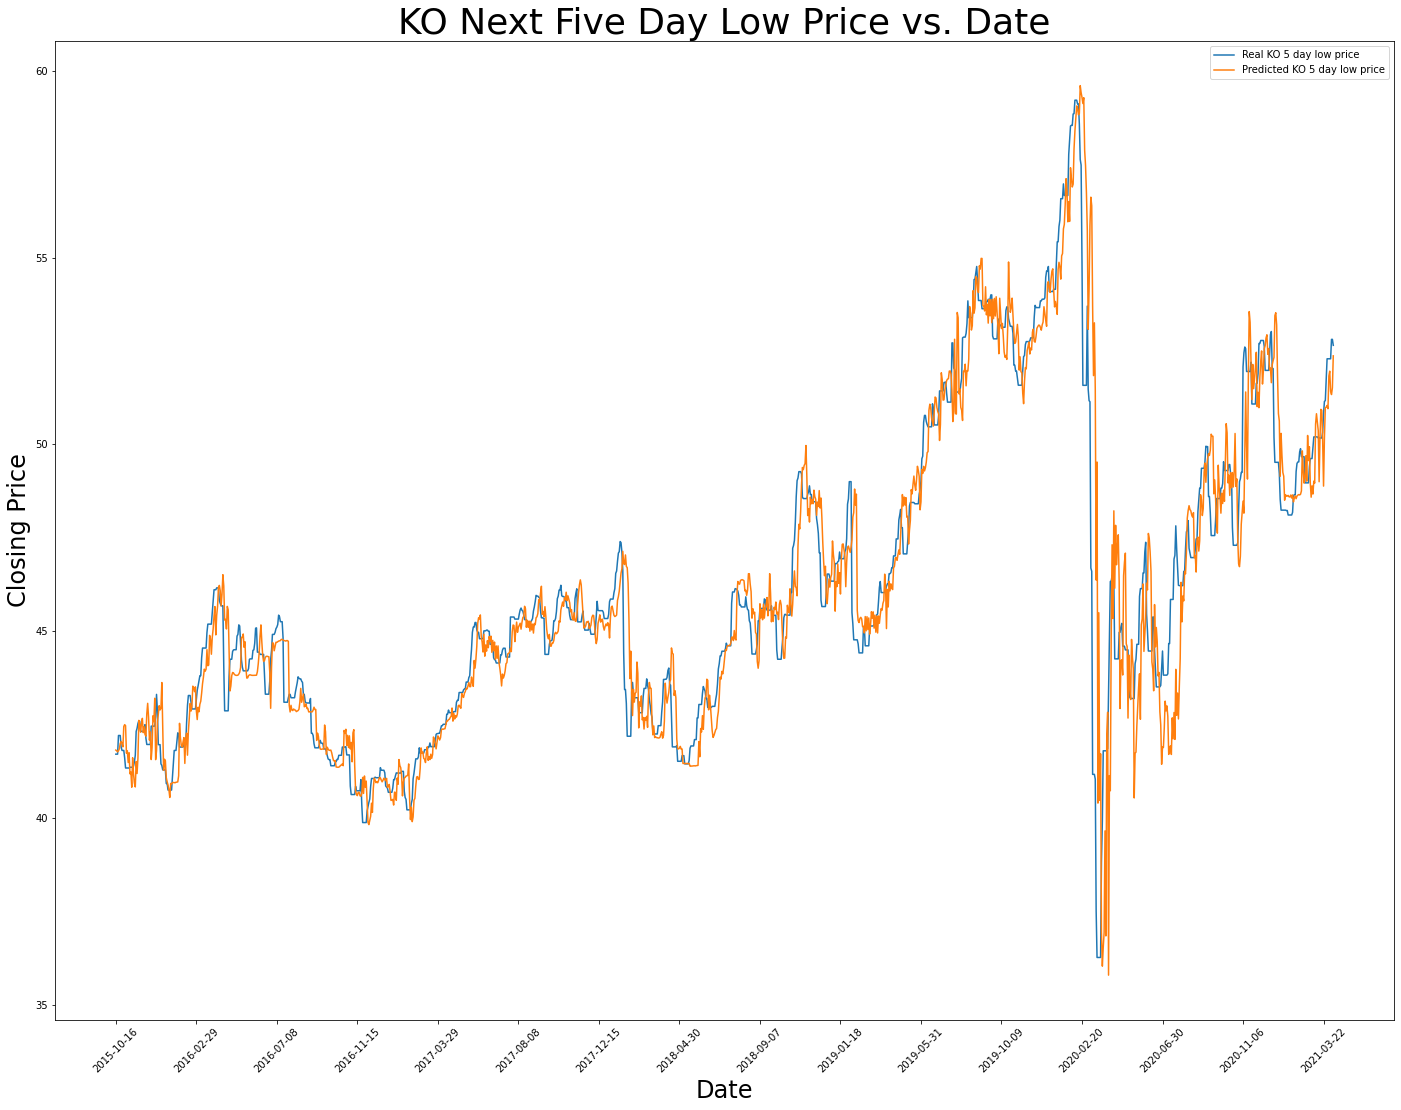

In [ ]:
fig, y_true, y_predicted = get_results(five_day_low_df, train_scaled_five_day_low, arnold_next_low, title = "Next Five Day Low Price vs. Date", predicted_value_name = "5 day low price")
fig.show()

In [ ]:
import numpy as np 
metrics = ModelMetrics(y_true = np.array(y_true), y_predicted=np.array(y_predicted))
print(f'{FIVE_DAY_LOW_MODEL_NAME} achieved the folowing results:')
metrics.print_metrics()

KO_FIVE_DAY_LOW_MODEL.h5 achieved the folowing results:
Mean squared error:		 2.194735054410238
Root mean squared error:	 1.4814638214989384
Mean absolute error:		 0.8518823946463169
Mean absolute percentage error:	 0.018654747448251803
Mean percentage error:		 -0.0007191531578760658
Mean directional accuracy:	 0.25290697674418605
